<a href="https://colab.research.google.com/github/d00rk/COSE474Project/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting ###

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install foundation model - Segment Anything
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1c5ktlup
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1c5ktlup
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=04fd450a8d8fed6256b56fb76c2c5c2aa702752cdedd09587177dcefab9d8ea9
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc3vw5ou/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
# libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import transforms

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
# device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cuda


In [ ]:
# directory setting
class ROOTDIR:
  train_image_dir = '/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/image/train/'
  val_image_dir = '/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/image/val/'
  train_mask_dir = '/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/label/train/'
  val_mask_dir = '/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/label/val/'

In [ ]:
# image file list
train_images = sorted(glob.glob(ROOTDIR.train_image_dir+"*.png"))
train_masks = sorted(glob.glob(ROOTDIR.train_mask_dir+"*.png"))
val_images = sorted(glob.glob(ROOTDIR.val_image_dir+"*.png"))
val_masks = sorted(glob.glob(ROOTDIR.val_mask_dir+"*.png"))

print(len(train_images), len(train_masks))
print(len(val_images), len(val_masks))

2975 2975
500 500


In [ ]:
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.1)

In [ ]:
print(len(val_images), len(val_masks))
print(len(test_images), len(test_masks))

450 450
50 50


In [ ]:
# image visualization function
def show(img_list, idx):
  img = Image.open(img_list[idx])
  print(f"Image path: {img_list[idx]}")
  plt.imshow(img)
  plt.show()

Image path: /content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/image/train/train0001.png


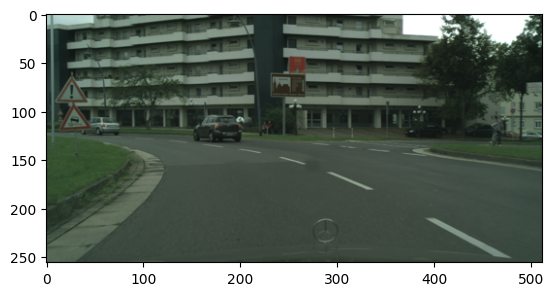

Image path: /content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/data/label/train/train0001.png


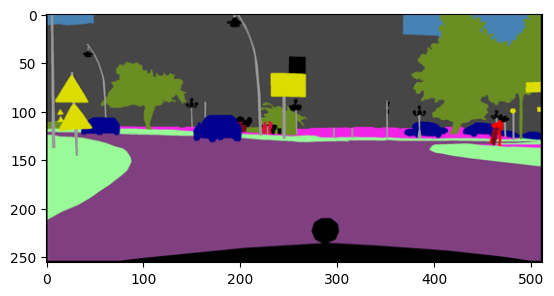

In [ ]:
show(img_list=train_images, idx=0)
show(img_list=train_masks, idx=0)

### Prepare Dataset ###

In [ ]:
# Dataset
class Cityscape(Dataset):
    def __init__(self, img_path, mask_path, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform

    # img list 길이
    def __len__(self):
        return len(self.img_path)

    # get image, label
    def __getitem__(self, idx):
        img = Image.open(self.img_path[idx]).convert("RGB")
        mask = Image.open(self.mask_path[idx]).convert("RGB")

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image = img, mask = mask)
            img, mask = augmented['image'], augmented['mask']
            img = torch.from_numpy(img).permute(2, 0, 1)
            mask = torch.from_numpy(mask).permute(2, 0, 1)
            return img, mask

        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        return img, mask

In [ ]:
# Data Augmentation
train_dataset = Cityscape(train_images, train_masks, None)
val_dataset = Cityscape(val_images, val_masks, None)

In [ ]:
# Batch
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, 1, shuffle=True)

### Zero-shot mask prediction ###

In [ ]:
# only one batch
images, masks = next(iter(train_loader))

In [ ]:
# predicted mask visualization function
def show_mask(masks):
  if len(masks) == 0:
    return
  sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  polygons = []
  color = []
  for ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
      img[:, :, i] = color_mask[i]
    ax.imshow(np.dstack((img, m*0.35)))

In [ ]:
# SAM model
model_type = "vit_h"
sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/Github/COSE474Project/sam_vit_h_4b8939.pth"

# automatic mask generator
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

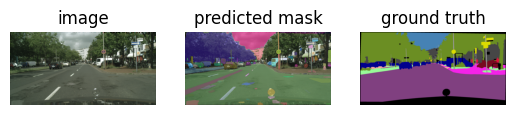

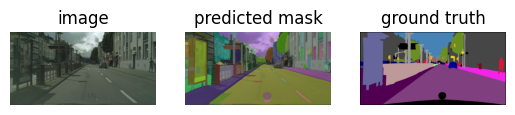

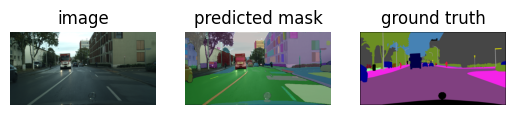

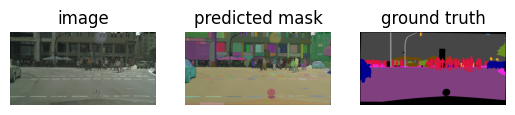

In [ ]:
for i in range(batch_size):
  x = np.array(images[i].permute(1, 2, 0))
  y = np.array(masks[i].permute(1, 2, 0))

  y_pred = mask_generator.generate(x)

  # plot original image
  plt.subplot(1, 3, 1)
  plt.imshow(x)
  plt.title('image')
  plt.axis('off')

  # plot predicted mask
  plt.subplot(1, 3, 2)
  plt.imshow(x)
  show_mask(y_pred)
  plt.title('predicted mask')
  plt.axis('off')

  # plot ground truth
  plt.subplot(1, 3, 3)
  plt.imshow(y)
  plt.title('ground truth')
  plt.axis('off')

  plt.show()

### Training for few datas ###

In [ ]:
epochs = 100
losses = []

for epoch in range(epochs):
  epoch_losses = []
